# Statistical analysis and visualization of the results from the two methods

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import csv
import seaborn as sns

import statistics

from scipy.stats import wilcoxon
import sklearn
from sklearn.metrics import mean_squared_error

## Initialize some paths and variables

In [2]:
path_parent = os.path.dirname(os.getcwd())
rootdir = os.path.join(path_parent, "results")
subdirs = ["orcnn_postprocessing", "mrcnn_postprocessing"]
labels = ["ORCNN & Post-processing", "MRCNN & Post-processing"]
colors = ["blue", "orange"]

image_num = 487
font_size = 11
digit_size = 9

## Store the results in one array

In [3]:
data_combined = np.zeros((image_num*len(subdirs), 11), dtype = object)
counter = 0

for i in range(len(subdirs)):
    subdir = subdirs[i]
    label = labels[i]
    readdir = os.path.join(rootdir, subdir)
    csvfile = "results_" + subdir + ".csv"

    readfile = os.path.join(readdir, csvfile)

    with open(readfile, 'r') as read_obj:
        csv_reader = csv.reader(read_obj)
        next(csv_reader, None)
        for row in csv_reader:
            img_name = row[0]
            amodal_iou = row[1]
            visible_iou = row[2]
            estimated_diameter = row[3]
            real_diameter = row[4]
            diff = row[5]
            ocr = row[6]
            analysis_time = row[7]

            data_combined[counter, 0] = img_name
            data_combined[counter, 1] = float(amodal_iou)
            data_combined[counter, 2] = float(visible_iou)
            data_combined[counter, 3] = float(estimated_diameter)
            data_combined[counter, 4] = float(real_diameter)
            data_combined[counter, 5] = float(diff)
            data_combined[counter, 6] = abs(float(diff))
            data_combined[counter, 7] = round(statistics.ceil_to_decimal(float(ocr)), 1)
            data_combined[counter, 8] = analysis_time
            data_combined[counter, 9] = i
            data_combined[counter, 10] = label
            counter = counter+1

## Initialize a dataframe, which will store the results

In [4]:
df = pd.DataFrame(data=data_combined, columns=["name", "amodal_iou", "visible_iou", "pred_d", "real_d", "diff", "abs_diff", "ocr", "time", "method_id", "method"])
df["abs_diff"] = df["abs_diff"].astype(float)
avg_diff = df.groupby(["method"])["abs_diff"].mean()
max_diff = df.groupby(["method"])["abs_diff"].max()

df["diff"] = df["diff"].astype(float)
diffs = df.groupby(["method"])["diff"].apply(list)
pred_diameters = df.groupby(["method"])["pred_d"].apply(list)
real_diameters = df.groupby(["method"])["real_d"].apply(list)

df["amodal_iou"] = df["amodal_iou"].astype(float)
df["visible_iou"] = df["visible_iou"].astype(float)
df["time"] = df["time"].astype(float)
df["method_id"] = df["method_id"].astype(int)

## Do some summary statistics and plot a histogram

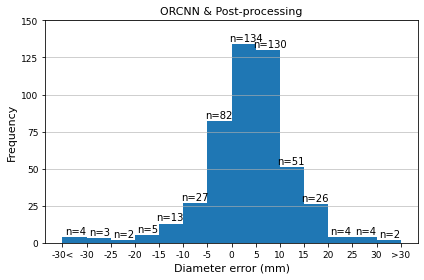

AVG absolute diameter error: 7.3 mm
MAX absolute diameter error: 80.2 mm
RMSE of diameter: 10.5

76.6% (373 of 487) of the estimates are within 10 mm from the real diameter
96.1% (468 of 487) of the estimates are within 20 mm from the real diameter
98.8% (481 of 487) of the estimates are within 30 mm from the real diameter
1.2% (6 of 487) of the estimates deviate more than 30 mm from the real diameter



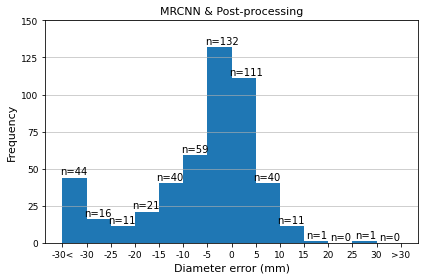

AVG absolute diameter error: 10.8 mm
MAX absolute diameter error: 123.1 mm
RMSE of diameter: 18.8

70.2% (342 of 487) of the estimates are within 10 mm from the real diameter
85.2% (415 of 487) of the estimates are within 20 mm from the real diameter
91.0% (443 of 487) of the estimates are within 30 mm from the real diameter
9.0% (44 of 487) of the estimates deviate more than 30 mm from the real diameter



In [5]:
for i in range(len(labels)):
    label = labels[i]
    bins, counts = statistics.histogram_error_fixed_scale(np.asarray(diffs[label]), label, -35, 35, 70, 14, digit_size, font_size)

    print("AVG absolute diameter error: {0:.1f} mm".format(avg_diff[label]))
    print("MAX absolute diameter error: {0:.1f} mm".format(max_diff[label]))

    rmse = mean_squared_error(real_diameters[label], pred_diameters[label], squared=False)
    print("RMSE of diameter: {0:.1f}".format(rmse))
    print("")
    
    statistics.counts_between(bins, counts, 10)
    statistics.counts_between(bins, counts, 20)
    statistics.counts_between(bins, counts, 30)
    statistics.counts_larger(bins, counts, 30)
    print("")

## Plot a combined empirical cumulative distribution function

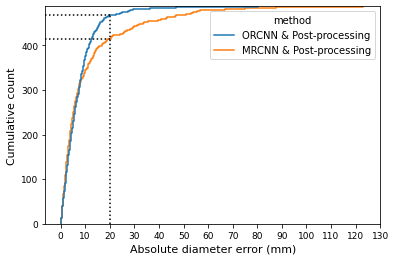

In [6]:
sns.ecdfplot(data=df, x="abs_diff", hue="method", stat="count")

plt.xticks(range(0, 140, 10), fontsize=digit_size)
plt.yticks(fontsize=digit_size)
plt.xlabel("Absolute diameter error (mm)", fontsize=font_size)
plt.ylabel("Cumulative count", fontsize=font_size)
plt.axvline(x=20, ymin=0, ymax=0.965, color='k', linestyle='dotted')
plt.axhline(xmin=0, xmax=0.2, y=415, color='k', linestyle='dotted')
plt.axhline(xmin=0, xmax=0.2, y=468, color='k', linestyle='dotted')
plt.show()

## Plot a combined kernel density estimate

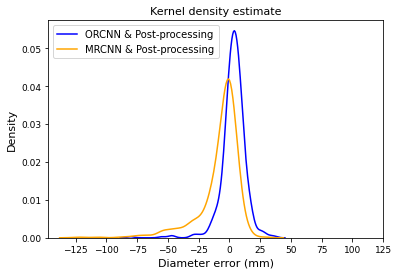

In [7]:
for i in range(len(labels)):
    label = labels[i]
    color = colors[i]
    sns.kdeplot(diffs[label] , color=color, label=label)
    
plt.xticks(range(-125, 150, 25), fontsize=digit_size)
plt.yticks(fontsize=digit_size)
plt.xlabel("Diameter error (mm)", fontsize=font_size)
plt.ylabel("Density", fontsize=font_size)
plt.title("Kernel density estimate", fontsize=font_size)
plt.legend()
plt.show()

## Store the unique occlusion rates as 10 bins

In [8]:
unique_ocrs = list(set(df["ocr"]))
unique_ocrs.sort()
ocr_counts = np.zeros(len(unique_ocrs)).astype(np.uint8)

x_ticks_list = []

for j in range(len(unique_ocrs)):
    unique_ocr = unique_ocrs[j]
    ocr_count = int(len(np.where(df["ocr"] == unique_ocr)[0])/3)
    ocr_counts[j] = ocr_count

    x_ticks_list.append('{0:.1f}-{1:.1f}'.format(unique_ocr-0.1, unique_ocr))

## Make a combined line-plot of the amodal IoU as a function of the occlusion rate

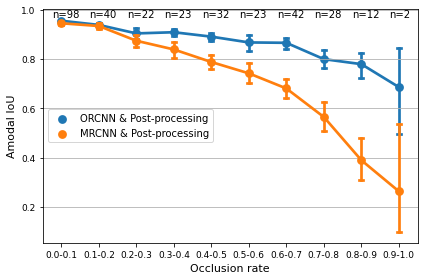

In [9]:
g = sns.pointplot(x="ocr", y="amodal_iou", hue="method", data=df, capsize=.1)
g.get_legend().remove()
plt.legend(loc='center left')

for count, x in zip(ocr_counts, unique_ocrs):
    plt.annotate('n={:.0f}'.format(count), ((x*10)-1.25, 0.97))

plt.xticks(np.arange(len(unique_ocrs)), x_ticks_list, fontsize=digit_size)
plt.xlabel("Occlusion rate", fontsize=font_size)

plt.yticks(fontsize=digit_size)
plt.ylabel("Amodal IoU", fontsize=11)
plt.grid(which='major', axis='y', linestyle='-')

plt.tight_layout()
plt.show()

## Make a combined line-plot of the visible IoU as a function of the occlusion rate

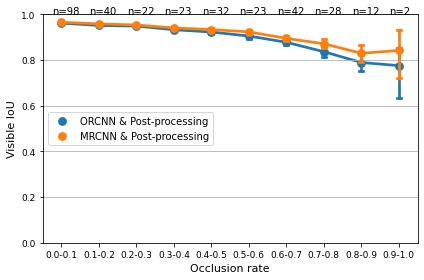

In [10]:
g = sns.pointplot(x="ocr", y="visible_iou", hue="method", data=df, capsize=.1)
g.get_legend().remove()
plt.legend(loc='center left')

for count, x in zip(ocr_counts, unique_ocrs):
    plt.annotate('n={:.0f}'.format(count), ((x*10)-1.25, 1))

plt.xticks(np.arange(len(unique_ocrs)), x_ticks_list, fontsize=digit_size)
plt.xlabel("Occlusion rate", fontsize=font_size)

plt.yticks(np.arange(0, 1.2, 0.2), fontsize=digit_size)
plt.ylabel("Visible IoU", fontsize=11)
plt.grid(which='major', axis='y', linestyle='-')

plt.tight_layout()
plt.show()

## Make a combined line-plot of the diameter error as a function of the occlusion rate

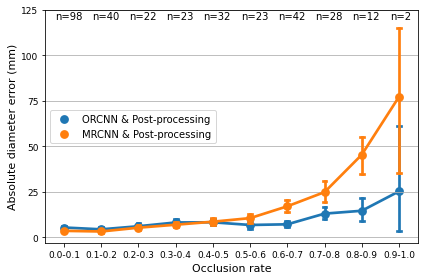

In [11]:
bin_step = 25
max_val = statistics.ceil_to_25(np.max(df["abs_diff"]))

g = sns.pointplot(x="ocr", y="abs_diff", hue="method", data=df, capsize=.1)
g.get_legend().remove()
plt.legend(loc='center left')

for count, x in zip(ocr_counts, unique_ocrs):
    plt.annotate('n={:.0f}'.format(count), ((x*10)-1.25, 120))

plt.xticks(np.arange(len(unique_ocrs)), x_ticks_list, fontsize=digit_size)
plt.xlabel("Occlusion rate", fontsize=font_size)

plt.yticks(range(0, int(max_val) + bin_step, bin_step), fontsize=digit_size)
plt.ylabel("Absolute diameter error (mm)", fontsize=11)
plt.grid(which='major', axis='y', linestyle='-')

plt.tight_layout()
plt.show()

## Make a dual y-axis line-plot of the diameter error and the amodal IoU as a function of the occlusion rate

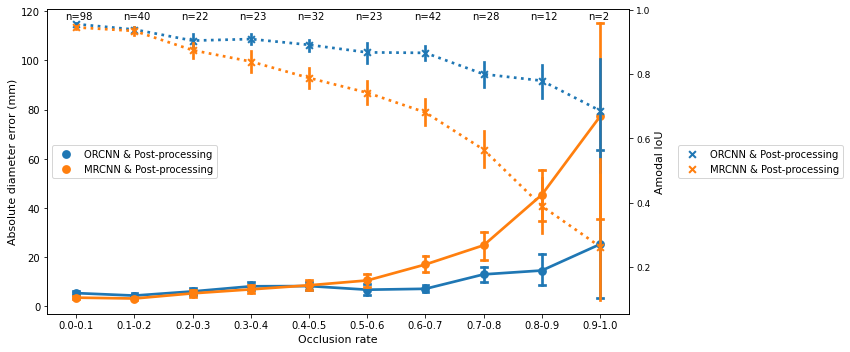

In [12]:
fig, ax1 = plt.subplots(figsize=(12, 5))
g1 = sns.pointplot(x="ocr", y="abs_diff", hue="method", data=df, ax=ax1, capsize=.1)
g1.get_legend().remove()
ax1.set_xlabel("Occlusion rate", fontsize=font_size)
ax1.set_ylabel("Absolute diameter error (mm)", fontsize=font_size)
ax1.legend(loc='center left')

ax2 = ax1.twinx()
g2 = sns.pointplot(x="ocr", y="amodal_iou", hue="method", data=df, ax=ax2, markers=["x", "x", "x"], linestyles=[":", ":", ":"])
g2.get_legend().remove()
ax2.set_ylabel("Amodal IoU", fontsize=font_size)
ax2.legend(loc='center left', bbox_to_anchor=(1.075, 0.5))

for count, x in zip(ocr_counts, unique_ocrs):
    plt.annotate('n={:.0f}'.format(count), ((x*10)-1.2, 0.97))

plt.xticks(np.arange(len(unique_ocrs)), x_ticks_list, fontsize=digit_size)
plt.yticks(fontsize=digit_size)

plt.tight_layout()
plt.show()

## Boxplot with the inference times for all methods

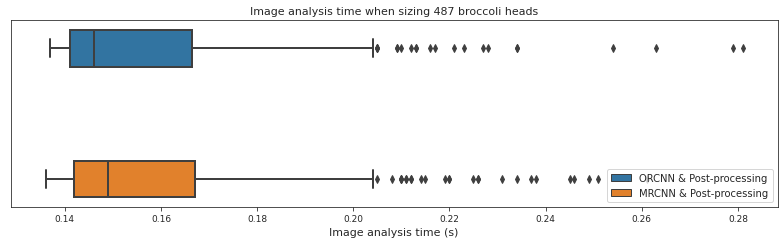

In [13]:
sns.set_style("ticks")
f, ax = plt.subplots(figsize=(11, 3.5))

ax = sns.boxplot(x="time", y="method_id", hue="method", orient="h", linewidth=2, data=df)
ax.set_ylabel('')
plt.legend(loc='lower right')

plt.xlabel('Image analysis time (s)', fontsize=font_size)
plt.xticks(fontsize=digit_size)
plt.yticks([])

plt.title("Image analysis time when sizing {0:.0f} broccoli heads".format(image_num), fontsize=font_size)

plt.tight_layout()
plt.show()

## Wilcoxon Signed-Rank Test of amodal IoU for each occlusion rate

In [14]:
## thanks to: https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
iou = df.groupby(["name", "ocr", "method"])["amodal_iou"].apply(list)
ocr = df.groupby(["name"])["ocr"].apply(list)

ids1 = np.arange(0, len(iou), 2)
ids2 = np.arange(1, len(iou), 2)

iou_mp = np.zeros(len(ids1)).astype(np.float32)
iou_op = np.zeros(len(ids2)).astype(np.float32)

ocrs = np.zeros(len(ids1)).astype(np.float32)

for i in range(len(iou)):
    if i in ids1:
        idx = int(i/2)
        iou_mp[idx] = iou[i][0]
        ocrs[idx] = ocr[idx][0]
    if i in ids2:
        idx = int((i-1)/2)
        iou_op[idx] = iou[i][0]
        
alpha = 0.05
print("{:<25} {:<51} {:<25}".format('', 'AVG (STD) of Amodal Intersection over Union', 'P-value Wilcoxon'))
print("{:<25} {:<25} {:<25} {:<25}".format('Occlusion rate', 'MP', 'OP', 'MP-OP'))

for j in range(len(unique_ocrs)):
    unique_ocr = unique_ocrs[j]    
    idxs = np.where(ocrs == unique_ocr)[0]
    
    m_p = []
    o_p = []
    
    for k in range(len(idxs)):
        idx = idxs[k]
        m_p.append(iou_mp[idx])
        o_p.append(iou_op[idx])
        
    stat, p_mp_op = wilcoxon(m_p, o_p)
    
    ocr_string = '{0:.1f}-{1:.1f}'.format(unique_ocr-0.1, unique_ocr)
    avgstd_mp = '{0:.2f} ({1:.2f})'.format(np.average(m_p), np.std(m_p))
    avgstd_op = '{0:.2f} ({1:.2f})'.format(np.average(o_p), np.std(o_p))

    if j != (len(unique_ocrs)-1):
        p_mp_op = '{0:.2f}'.format(p_mp_op)
    else:
        p_mp_op = '*'

    print("{:<25} {:<25} {:<25} {:<25}".format(ocr_string, avgstd_mp, avgstd_op, p_mp_op))
    
print("")
print("Explanation:")
print("MP : Mask R-CNN & Post-processing")
print("OP : ORCNN & Post-processing")
print("")
print("MP-OP : rank comparison between Mask R-CNN & Post-processing and ORCNN & Post-processing")
print("")
print("* : sample size too small for normal approximation")
print("")
print("The P-values lower than 0.05 indicate that the tested distributions are significantly different")

                          AVG (STD) of Amodal Intersection over Union         P-value Wilcoxon         
Occlusion rate            MP                        OP                        MP-OP                    
0.0-0.1                   0.95 (0.03)               0.96 (0.03)               0.00                     
0.1-0.2                   0.93 (0.05)               0.94 (0.03)               0.65                     
0.2-0.3                   0.87 (0.07)               0.90 (0.07)               0.03                     
0.3-0.4                   0.84 (0.10)               0.91 (0.05)               0.00                     
0.4-0.5                   0.79 (0.11)               0.89 (0.06)               0.00                     
0.5-0.6                   0.74 (0.12)               0.87 (0.10)               0.00                     
0.6-0.7                   0.68 (0.16)               0.87 (0.09)               0.00                     
0.7-0.8                   0.57 (0.20)               0.80 (0.12) 

## Wilcoxon Signed-Rank Test of diameter error for each occlusion rate

In [15]:
## thanks to: https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
abs_diff = df.groupby(["name", "ocr", "method"])["abs_diff"].apply(list)
ocr = df.groupby(["name"])["ocr"].apply(list)

ids1 = np.arange(0, len(abs_diff), 2)
ids2 = np.arange(1, len(abs_diff), 2)

abs_diff_mp = np.zeros(len(ids1)).astype(np.float32)
abs_diff_op = np.zeros(len(ids2)).astype(np.float32)

ocrs = np.zeros(len(ids1)).astype(np.float32)

for i in range(len(abs_diff)):
    if i in ids1:
        idx = int(i/2)
        abs_diff_mp[idx] = abs_diff[i][0]
        ocrs[idx] = ocr[idx][0]
    if i in ids2:
        idx = int((i-1)/2)
        abs_diff_op[idx] = abs_diff[i][0]
        
        
alpha = 0.05
print("{:<25} {:<51} {:<25}".format('', 'AVG (STD) of absolute diameter error (mm)', 'P-value Wilcoxon'))
print("{:<25} {:<25} {:<25} {:<25}".format('Occlusion rate', 'MP', 'OP', 'MP-OP'))

for j in range(len(unique_ocrs)):
    unique_ocr = unique_ocrs[j]    
    idxs = np.where(ocrs == unique_ocr)[0]
    
    m_p = []
    o_p = []
    
    for k in range(len(idxs)):
        idx = idxs[k]
        m_p.append(abs_diff_mp[idx])
        o_p.append(abs_diff_op[idx])
        
    stat, p_mp_op = wilcoxon(m_p, o_p)
    
    ocr_string = '{0:.1f}-{1:.1f}'.format(unique_ocr-0.1, unique_ocr)
    avgstd_mp = '{0:.1f} ({1:.1f})'.format(np.average(m_p), np.std(m_p))
    avgstd_op = '{0:.1f} ({1:.1f})'.format(np.average(o_p), np.std(o_p))

    if j != (len(unique_ocrs)-1):
        p_mp_op = '{0:.2f}'.format(p_mp_op)
    else:
        p_mp_op = '*'

    print("{:<25} {:<25} {:<25} {:<25}".format(ocr_string, avgstd_mp, avgstd_op, p_mp_op))
    
print("")
print("Explanation:")
print("MP : Mask R-CNN & Post-processing")
print("OP : ORCNN & Post-processing")
print("")
print("MP-OP : rank comparison between Mask R-CNN & Post-processing and ORCNN & Post-processing")
print("")
print("* : sample size too small for normal approximation")
print("")
print("The P-values lower than 0.05 indicate that the tested distributions are significantly different")

                          AVG (STD) of absolute diameter error (mm)           P-value Wilcoxon         
Occlusion rate            MP                        OP                        MP-OP                    
0.0-0.1                   3.6 (3.1)                 5.4 (4.2)                 0.00                     
0.1-0.2                   3.2 (2.6)                 4.4 (3.9)                 0.05                     
0.2-0.3                   5.3 (4.1)                 6.1 (4.5)                 0.52                     
0.3-0.4                   7.0 (4.8)                 8.2 (4.9)                 0.28                     
0.4-0.5                   8.6 (7.0)                 8.3 (5.8)                 1.00                     
0.5-0.6                   10.6 (7.8)                6.8 (6.9)                 0.07                     
0.6-0.7                   17.1 (13.7)               7.2 (5.9)                 0.00                     
0.7-0.8                   24.9 (18.7)               13.1 (10.3) 